In [ ]:
import tensorflow as tf
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import  Dense, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Lambda 
from keras.layers import Reshape
from matplotlib import pyplot
from keras import backend
from keras.utils.vis_utils import plot_model
from numpy import expand_dims
from keras.layers import Activation

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint

In [ ]:
(trainX, trainy), (_, _) = load_data()
X = expand_dims(trainX, axis=-1)
X = X.astype('float32')
X = (X - 127.5) / 127.5
print(X.shape, trainy.shape)
dataset=[X, trainy]

(60000, 28, 28, 1) (60000,)


In [ ]:
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

In [ ]:
def discriminator(in_shape=(28,28,1), n_classes=10):

	input = Input(shape=in_shape)
 
	output = Conv2D(128, (3,3), strides=(2,2), padding='same')(input)
	output = LeakyReLU(alpha=0.2)(output)
 
	output = Conv2D(128, (3,3), strides=(2,2), padding='same')(output)
	output = LeakyReLU(alpha=0.2)(output)

	output = Conv2D(128, (3,3), strides=(2,2), padding='same')(output)
	output = LeakyReLU(alpha=0.2)(output)

	output = Flatten()(output)
	output = Dropout(0.4)(output)
	# output layer nodes
	output = Dense(n_classes)(output)
 
	c_out_layer = Activation('softmax')(output)
	c_model = Model(input, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

	d_out_layer = Lambda(custom_activation)(output)

	d_model = Model(input, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return d_model, c_model

d_model, c_model = discriminator()



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


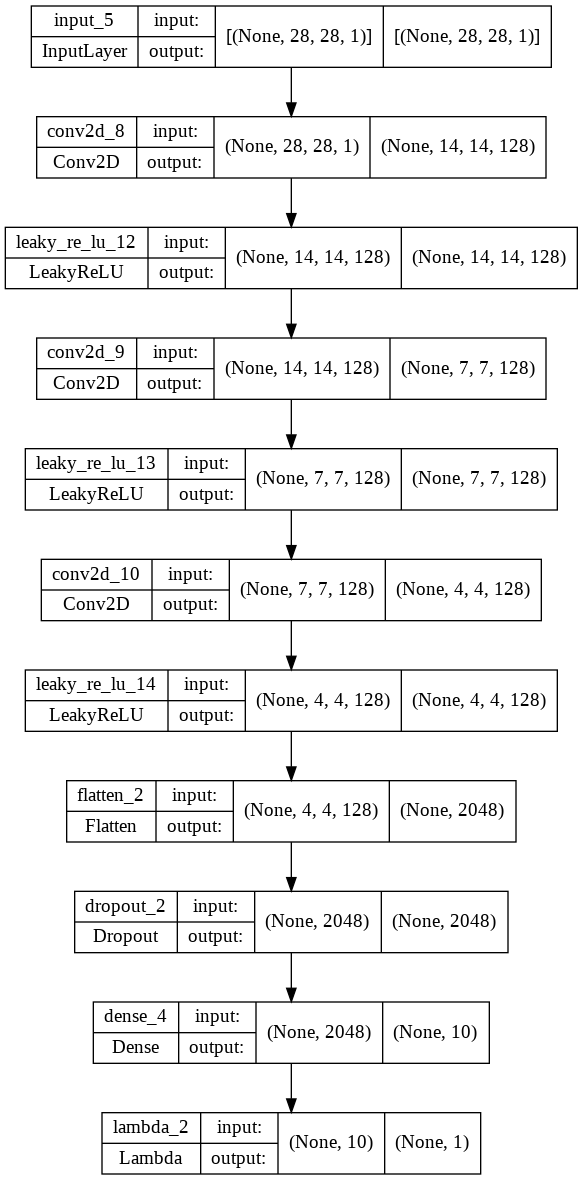

In [ ]:
plot_model(d_model, to_file='discriminator1_plot.png', show_shapes=True, show_layer_names=True)

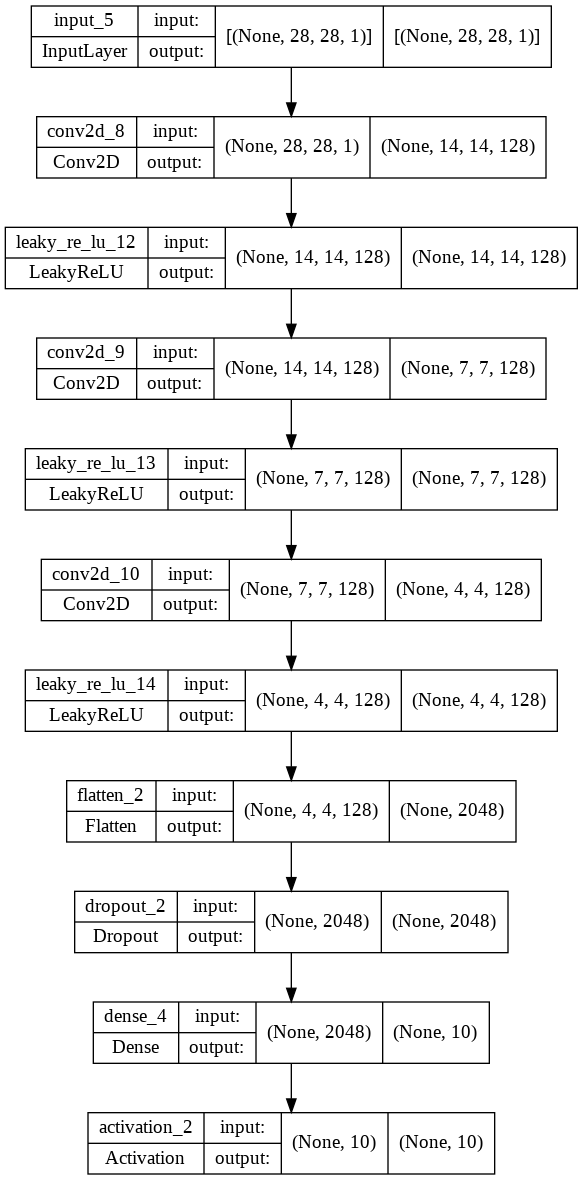

In [ ]:
plot_model(c_model, to_file='discriminator2_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def generator(latent_dim):
	noise = Input(shape=(latent_dim,))
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(noise)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)

	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)

	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	model = Model(noise, out_layer)
	return model

In [ ]:
def GAN(g_model, d_model):
	d_model.trainable = False
	gan_output = d_model(g_model.output)
	model = Model(g_model.input, gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
 
	return model

In [ ]:
def supervised_samples(dataset, n_samples=100, n_classes=10):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		X_with_class = X[y == i]
		ix = randint(0, len(X_with_class), n_per_class)
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return asarray(X_list), asarray(y_list)


In [ ]:
def real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y

In [ ]:
def latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input

In [ ]:
def fake_samples(generator, latent_dim, n_samples):
	z_input = latent_points(latent_dim, n_samples)
	images = generator.predict(z_input)
	y = zeros((n_samples, 1))
	return images, y

In [ ]:
def performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	X, _ =fake_samples(g_model, latent_dim, n_samples)
	X = (X + 1) / 2.0

	for i in range(100):
		pyplot.subplot(10, 10, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()

	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))

	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the classifier model
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [ ]:
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=100):

	X_sup, y_sup = supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
 
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))

	for i in range(n_steps):

		[Xsup_real, ysup_real], _ = real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		[X_real, _], y_real = real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)

		X_gan, y_gan = latent_points(latent_dim, n_batch), ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
		#print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 1) == 0:
			performance(i, g_model, c_model, latent_dim, dataset)

In [ ]:
latent_dim = 100
g_model = generator(latent_dim)

gan_model = GAN(g_model, d_model)

train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(100, 28, 28, 1) (100,)
n_epochs=10, n_batch=100, 1/2=50, b/e=600, steps=6000
Classifier Accuracy: 83.390%
>Saved: generated_plot_0600.png, g_model_0600.h5, and c_model_0600.h5
Classifier Accuracy: 90.832%
>Saved: generated_plot_1200.png, g_model_1200.h5, and c_model_1200.h5
Classifier Accuracy: 91.885%
>Saved: generated_plot_1800.png, g_model_1800.h5, and c_model_1800.h5
Classifier Accuracy: 93.362%
>Saved: generated_plot_2400.png, g_model_2400.h5, and c_model_2400.h5
Classifier Accuracy: 93.455%
>Saved: generated_plot_3000.png, g_model_3000.h5, and c_model_3000.h5
Classifier Accuracy: 94.460%
>Saved: generated_plot_3600.png, g_model_3600.h5, and c_model_3600.h5
Classifier Accuracy: 94.380%
>Saved: generated_plot_4200.png, g_model_4200.h5, and c_model_4200.h5
Classifier Accuracy: 94.585%
>Saved: generated_plot_4800.png, g_model_4800.h5, and c_model_4800.h5
Classifier Accuracy: 94.787%
>Saved: generated_plot_5400.png, g_model_5400.h5, and c_model_5400.h5
Classifier Accuracy: 94.268%
>S

# Q3


In [ ]:
def train(g_model, d_model, c_model,  dataset, latent_dim, n_epochs=10, n_batch=100):

	X_sup, y_sup = supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
 
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	n_steps = bat_per_epo * n_epochs
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))

	for i in range(n_steps):

		[Xsup_real, ysup_real], _ = real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
		[X_real, _], y_real = real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)

		#X_gan, y_gan = latent_points(latent_dim, n_batch), ones((n_batch, 1))
		#g_loss = gan_model.train_on_batch(X_gan, y_gan)
		#print('>%d, c[%.3f,%.0f], d[%.3f,%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2))
		if (i+1) % (bat_per_epo * 1) == 0:
			performance(i, g_model, c_model, latent_dim, dataset)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model2, c_model2 = discriminator()
# create the generator
g_model2 = generator(latent_dim)
# create the gan
#gan_model2 = GAN(g_model, d_model)
# train model
train(g_model2, d_model2, c_model2, dataset, latent_dim)

(100, 28, 28, 1) (100,)
n_epochs=10, n_batch=100, 1/2=50, b/e=600, steps=6000


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Classifier Accuracy: 79.350%
>Saved: generated_plot_0600.png, g_model_0600.h5, and c_model_0600.h5
Classifier Accuracy: 79.465%
>Saved: generated_plot_1200.png, g_model_1200.h5, and c_model_1200.h5
Classifier Accuracy: 79.567%
>Saved: generated_plot_1800.png, g_model_1800.h5, and c_model_1800.h5
Classifier Accuracy: 79.082%
>Saved: generated_plot_2400.png, g_model_2400.h5, and c_model_2400.h5
Classifier Accuracy: 79.348%
>Saved: generated_plot_3000.png, g_model_3000.h5, and c_model_3000.h5
Classifier Accuracy: 79.430%
>Saved: generated_plot_3600.png, g_model_3600.h5, and c_model_3600.h5
Classifier Accuracy: 79.478%
>Saved: generated_plot_4200.png, g_model_4200.h5, and c_model_4200.h5
Classifier Accuracy: 79.723%
>Saved: generated_plot_4800.png, g_model_4800.h5, and c_model_4800.h5
Classifier Accuracy: 79.682%
>Saved: generated_plot_5400.png, g_model_5400.h5, and c_model_5400.h5
Classifier Accuracy: 9.872%
>Saved: generated_plot_6000.png, g_model_6000.h5, and c_model_6000.h5
